In [ ]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from keras.layers import Dropout
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from pandas import concat
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Bidirectional
import pandas as pd
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import SimpleRNN
from tensorflow import optimizers


In [ ]:
# load dataset
dataset = read_csv('DATASETAIML3.csv', header=0, index_col=0)
values = dataset.values

In [ ]:
dataset.head()

,Date,Time,WS [m/s],DIR [°]
0,1201950000,0,6.99,37.08
1,1201950100,100,6.73,34.21
2,1201950200,200,6.55,31.23
3,1201950300,300,6.44,29.75
4,1201950400,400,6.33,28.83


In [ ]:
# dataset.dropna()
dataset.drop(dataset.columns[[1]], axis = 1, inplace = True)
print(dataset.head())

         Date  WS [m/s]  DIR [°]
0  1201950000      6.99    37.08
1  1201950100      6.73    34.21
2  1201950200      6.55    31.23
3  1201950300      6.44    29.75
4  1201950400      6.33    28.83


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
#dataset['Day'] = pd.to_datetime(dataset['Day'])
dataset = dataset.set_index('Date')
values = dataset.values
encoder = LabelEncoder()
values[:, 1] = encoder.fit_transform(values[:, 1])
values = values.astype(float)
scaler =  StandardScaler()
scaled = scaler.fit_transform(values)
print()
print(scaled[:, 1])


[-1.41118727 -1.44509529 -1.48030291 ... -1.39405605 -1.44769451
 -1.4983793 ]


In [ ]:
n_input = 3
n_features = 2

reframed = series_to_supervised(scaled, n_input, 1)
#Splitting the dataset
values = reframed.values
train = values[:140000, :]
test = values[140000:, :]

n_obs = n_input * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

train_X = train_X.reshape((train_X.shape[0], n_input, n_features))
test_X = test_X.reshape((test_X.shape[0], n_input, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(140000, 6) 140000 (140000,)
(140000, 3, 2) (140000,) (35317, 3, 2) (35317,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 64)             4288      
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 71,105
Trainable params: 71,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1945/1945 - 16s - loss: 0.0395 - val_loss: 0.0139 - 16s/epoch - 8ms/step
Epoch 2/50
1945/1945 - 13s - loss: 0.0131 - val_loss: 0.0116 - 13s/epoch - 7ms/step
Epoch 3/50
1945/

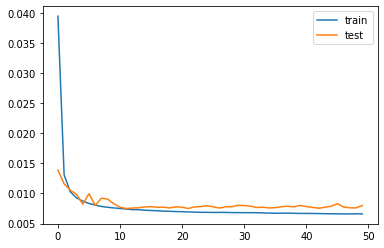

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(n_input, n_features), activation="relu",return_sequences=True))
model.add(LSTM(100,activation='relu'))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_input*n_features))
print(yhat.shape)
print(len(yhat))
print(test_y.shape)

(35317, 1)
35317
(35317,)


In [ ]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.089


In [ ]:
prediction_copies = np.repeat(yhat, scaled.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
#inv_yhat = concatenate((prediction_copies, test_X[:, -2:]), axis=1)
inv_yhat = scaler.inverse_transform(prediction_copies)
inv_yhat = inv_yhat[:,0]

In [ ]:
test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -2:]), axis=1)

test_copies = np.repeat(test_y, scaled.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

inv_y = scaler.inverse_transform(test_copies)
inv_y = inv_y[:,0]

mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test MAPE: %.3f' % mape)

Test MSE: 0.041
Test RMSE: 0.202
Test MAE: 0.154
Test MAPE: 0.039


In [ ]:
#print(yhat)
print(inv_yhat)

[7.7228227 7.669828  7.7164235 ... 5.7845325 6.1316633 6.292985 ]


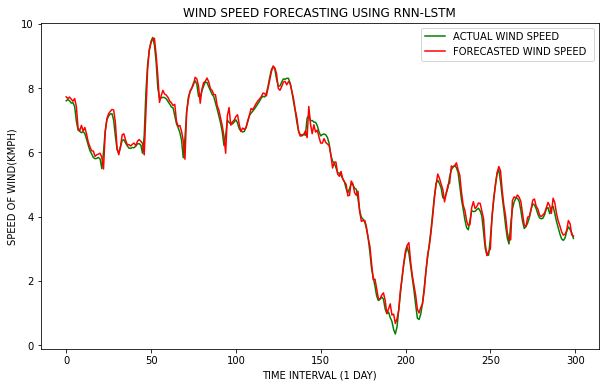

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt

#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(inv_y[:300], color= 'green',label = 'ACTUAL WIND SPEED ')
plt.plot(inv_yhat[:300] , color = 'red',label = 'FORECASTED WIND SPEED ')
plt.title("WIND SPEED FORECASTING USING RNN-LSTM")
plt.xlabel("TIME INTERVAL (1 DAY)")
plt.ylabel("SPEED OF WIND(KMPH)")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [ ]:
print(inv_y[:724])

[7.6  7.64 7.6  7.53 7.54 7.42 6.97 6.69 6.65 6.61 6.64 6.58 6.41 6.22
 6.05 5.95 5.84 5.8  5.81 5.84 5.79 5.49 6.01 6.67 7.01 7.13 7.19 7.2
 6.99 6.5  6.08 5.98 6.17 6.37 6.39 6.29 6.2  6.13 6.12 6.15 6.14 6.19
 6.26 6.27 6.22 5.97 6.53 7.88 8.73 9.18 9.45 9.57 9.34 8.82 8.   7.68
 7.69 7.71 7.7  7.66 7.58 7.5  7.41 7.38 7.13 6.89 6.76 6.62 6.37 5.83
 6.44 7.24 7.71 7.88 7.98 8.15 8.22 8.12 7.74 7.72 7.91 8.06 8.18 8.17
 8.04 7.92 7.8  7.73 7.54 7.34 7.13 6.91 6.63 6.21 6.51 7.   6.93 6.88
 6.88 6.94 7.01 6.91 6.73 6.66 6.63 6.65 6.77 6.94 7.14 7.22 7.28 7.35
 7.43 7.51 7.59 7.69 7.74 7.72 7.83 8.06 8.34 8.58 8.66 8.58 8.27 8.06
 8.06 8.18 8.28 8.27 8.3  8.3  8.14 7.9  7.57 7.28 6.92 6.66 6.54 6.51
 6.56 6.53 7.06 7.15 6.98 6.99 6.94 6.93 6.83 6.64 6.51 6.55 6.57 6.54
 6.46 6.27 5.91 5.72 5.67 5.52 5.37 5.35 5.28 5.18 5.08 4.87 4.73 4.87
 5.02 4.99 4.88 4.85 4.55 4.18 3.98 3.92 3.83 3.61 3.33 2.89 2.38 2.1
 1.84 1.53 1.39 1.43 1.5  1.43 1.13 0.98 1.03 0.86 0.74 0.49 0.35 0.57
 1.1  1.

In [ ]:
x=print(inv_yhat[:724])

[7.7228227  7.669828   7.7164235  7.653642   7.586679   7.669712
 7.418931   6.751647   6.6709833  6.838184   6.656236   6.771674
 6.568625   6.3166146  6.1686277  6.045326   6.0380874  5.873474
 5.92087    5.9457173  5.968482   5.842372   5.4819007  6.613085
 7.044347   7.1996727  7.2700405  7.332584   7.313579   6.915568
 6.1209836  5.9238057  6.1667247  6.542125   6.574615   6.3804555
 6.2365932  6.237202   6.1952496  6.249659   6.2871118  6.2037497
 6.340365   6.3957844  6.341074   6.275151   5.9186354  7.225616
 8.585964   9.186267   9.407817   9.531946   9.544566   9.04479
 8.385832   7.551704   7.754717   7.9247622  7.811147   7.7769012
 7.708262   7.592718   7.5403876  7.4518166  7.4927926  6.967848
 6.8067575  6.8326035  6.6527424  6.3499103  5.7840147  7.251297
 7.6291337  7.906347   7.996379   8.095543   8.332587   8.282323
 8.058345   7.5256767  7.953663   8.163399   8.206069   8.3085575
 8.190245   7.981958   7.921803   7.794706   7.7863746  7.4555044
 7.312457   7.0653005

In [ ]:
from numpy import savetxt
savetxt('new.csv', inv_yhat, delimiter='/n')
open("new.csv")

<_io.TextIOWrapper name='new.csv' mode='r' encoding='UTF-8'>

In [ ]:
from numpy import savetxt
savetxt('newa.csv', inv_y, delimiter='/n')
open("newa.csv")

<_io.TextIOWrapper name='newa.csv' mode='r' encoding='UTF-8'>